[INFO] loading images...


C:\Users\91934\anaconda3\envs\tensorflow\lib\site-packages\PIL\Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


[WARNING] Skipping unreadable image: C:\AI Course tamil\14.Deep Learning\Dogs_monitoring\dataset\stray_dogs\dbfb26ca-b633-11ec-a4f3-fc37f02059fa_1649389370387.avif
[WARNING] Skipping unreadable image: C:\AI Course tamil\14.Deep Learning\Dogs_monitoring\dataset\stray_dogs\GettyImages-136110195.avif
[WARNING] Skipping unreadable image: C:\AI Course tamil\14.Deep Learning\Dogs_monitoring\dataset\stray_dogs\Street-dogs-Hyderabad.avif
[WARNING] Skipping unreadable image: C:\AI Course tamil\14.Deep Learning\Dogs_monitoring\dataset\stray_dogs\Viral_Swarna__99_.avif
[INFO] compiling model...
[INFO] training head...
Epoch 1/20
27/27 [==============================] - 30s 887ms/step - loss: 0.7629 - accuracy: 0.5986 - val_loss: 0.5369 - val_accuracy: 0.7937
Epoch 2/20
27/27 [==============================] - 22s 820ms/step - loss: 0.5514 - accuracy: 0.7678 - val_loss: 0.4179 - val_accuracy: 0.8700
Epoch 3/20
27/27 [==============================] - 23s 831ms/step - loss: 0.4352 - accuracy: 0.844

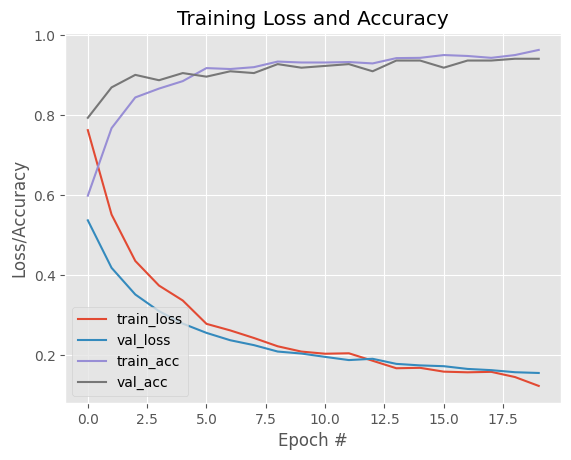

In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import UnidentifiedImageError

# initialize hyperparameters
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"C:\AI Course tamil\14.Deep Learning\Dogs_monitoring\dataset"
CATEGORIES = ["not_stray_dogs", "stray_dogs"]

# load and preprocess images
print("[INFO] loading images...")
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        try:
            image = load_img(img_path, target_size=(224, 224))
            image = img_to_array(image)
            image = preprocess_input(image)
            data.append(image)
            labels.append(category)
        except UnidentifiedImageError:
            print(f"[WARNING] Skipping unreadable image: {img_path}")
        except Exception as e:
            print(f"[ERROR] {e} in file: {img_path}")

# encode labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

# data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# load MobileNetV2 base
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# build head model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# attach head to base
model = Model(inputs=baseModel.input, outputs=headModel)

# freeze base layers
for layer in baseModel.layers:
    layer.trainable = False

# compile model (no decay)
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train model
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# evaluate
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

# save model
print("[INFO] saving model...")
model.save("stray_dogs_detector.model", save_format="h5")

# plot results
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")
